<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/Gradient_Feature_Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brain Tumor Dataset<br>
source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset<br>
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']<br>
number of training MRIs slices = 5712 <br>
number of testing MRIs slices = 1311 <br>

Download the dataset:

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1Oms9X0Vpid_kN8jiSgz-3MhRA5BcmivE'
gdown.download(url,'braintumor.zip',quiet=True)
!unzip -q braintumor.zip -d braintumor

In [ ]:
import gdown

!mkdir myweights

#ResNet34
url = 'https://drive.google.com/uc?id=19GYVgCz9wjO4wdCmFWhUw9_Uylzylfqe'
gdown.download(url,'myweights/best_model.pth.tar',quiet=True)

'myweights/best_model.pth.tar'

Download my trained weights:

In [ ]:
import gdown

!mkdir myweights

#ResNet34
url = 'https://drive.google.com/uc?id=19GYVgCz9wjO4wdCmFWhUw9_Uylzylfqe'
gdown.download(url,'myweights/best_model.pth.tar',quiet=True)

#DesnseNet121
url = 'https://drive.google.com/uc?id=1RQHQiF9LrRKbIUSaCOZd8-9paio6DFZ8'
gdown.download(url,'myweights/best_model_densenet8.pth.tar',quiet=True)

#ViT
url = 'https://drive.google.com/uc?id=1yYBUwjxmrjQevBPleZAQeEyHR-Pq5wWB'
gdown.download(url,'myweights/best_model_vit.pth.tar',quiet=True)

'myweights/best_model_vit.pth.tar'

Sample Data:

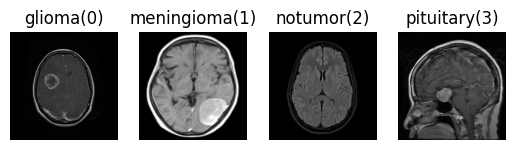

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
my_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])

class_names = ['glioma(0)', 'meningioma(1)', 'notumor(2)', 'pituitary(3)']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor/Testing/glioma/Te-gl_0014.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor/Testing/meningioma/Te-me_0017.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor/Testing/notumor/Te-noTr_0002.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor/Testing/pituitary/Te-piTr_0008.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

Generate GradCAM

<ipython-input-5-4ca57b04dab9>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('myweights/best_model.pth.tar'))


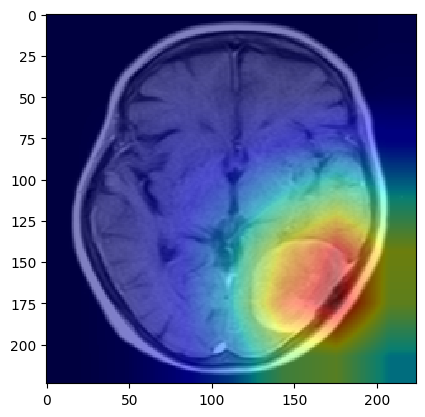

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        # get the pretrained VGG19 network
        self.model = models.resnet34()
        self.model.fc = nn.Linear(self.model.fc.in_features, 4)
        self.model.to(device)
        self.model.load_state_dict(torch.load('myweights/best_model.pth.tar'))

        # isolate the feature blocks
        self.features = nn.Sequential(self.model.conv1,
                                      self.model.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.model.layer1,
                                      self.model.layer2,
                                      self.model.layer3,
                                      self.model.layer4)

        # average pooling layer
        self.avgpool = self.model.avgpool

        # classifier
        self.classifier = self.model.fc

        # gradient placeholder
        self.gradient = None


    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad

    def get_gradient(self):
        return self.gradient

    def get_activations(self, x):
        return self.features(x)

    def forward(self, x):

        # extract the features
        x = self.features(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)

        return x

# init the resnet
resnet = ResNet()
resnet.eval()
img = my_transform(img_meningioma).unsqueeze(0).to(device)
logits = resnet(img)
pred = logits.argmax(dim=1).item()

# get the gradient of the output with respect to the parameters of the model
logits[:, pred].backward()

# pull the gradients out of the model
gradients = resnet.get_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = resnet.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap.cpu().numpy(), 0)

# normalize the heatmap
heatmap /= np.max(heatmap)

img_np = np.array(img_meningioma)
heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))

plt.imshow(img_np, interpolation='nearest', cmap='gray')
plt.imshow(heatmap, interpolation='nearest', cmap=cm.jet, alpha=0.5, vmin=0, vmax=1)

Simplified Version:

<ipython-input-6-a04d7d48d7e5>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('myweights/best_model.pth.tar'))
/usr/local/lib/python3.11/

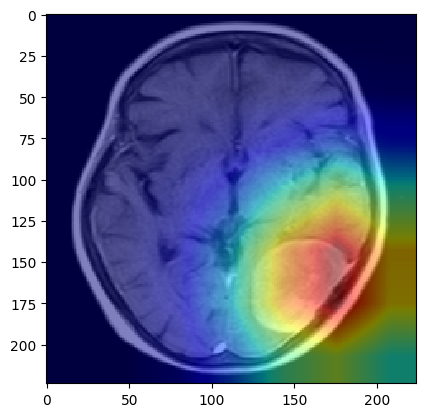

In [ ]:
import torch
import torch.nn.functional as F

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    model.eval()
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap

model = models.resnet34()
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load('myweights/best_model.pth.tar'))
model.eval()
last_conv_layer = model.layer4[2].conv2
img = my_transform(img_meningioma).unsqueeze(0)
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)


img_np = np.array(img_meningioma)
heatmap = cv2.resize(np.array(heatmap), (img_np.shape[1], img_np.shape[0]))

plt.imshow(img_np, interpolation='nearest', cmap='gray')
plt.imshow(heatmap, interpolation='nearest', cmap=cm.jet, alpha=0.5, vmin=0, vmax=1)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
my_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])


newsize = (224, 224)
img_meningioma = Image.open('/content/braintumor/Testing/meningioma/Te-me_0017.jpg').resize(newsize)

model = models.resnet34()
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load('myweights/best_model.pth.tar'))
model.eval()
img = my_transform(img_meningioma).unsqueeze(0)
model.eval()
logits = model(img)
pred = logits.argmax(dim=1).item()

<ipython-input-7-57efbc30e2c8>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('myweights/best_model.pth.tar'))


<ipython-input-20-812d8b9fa759>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('myweights/best_model.pth.tar', map_location=torch.device(

Predicted class: 1


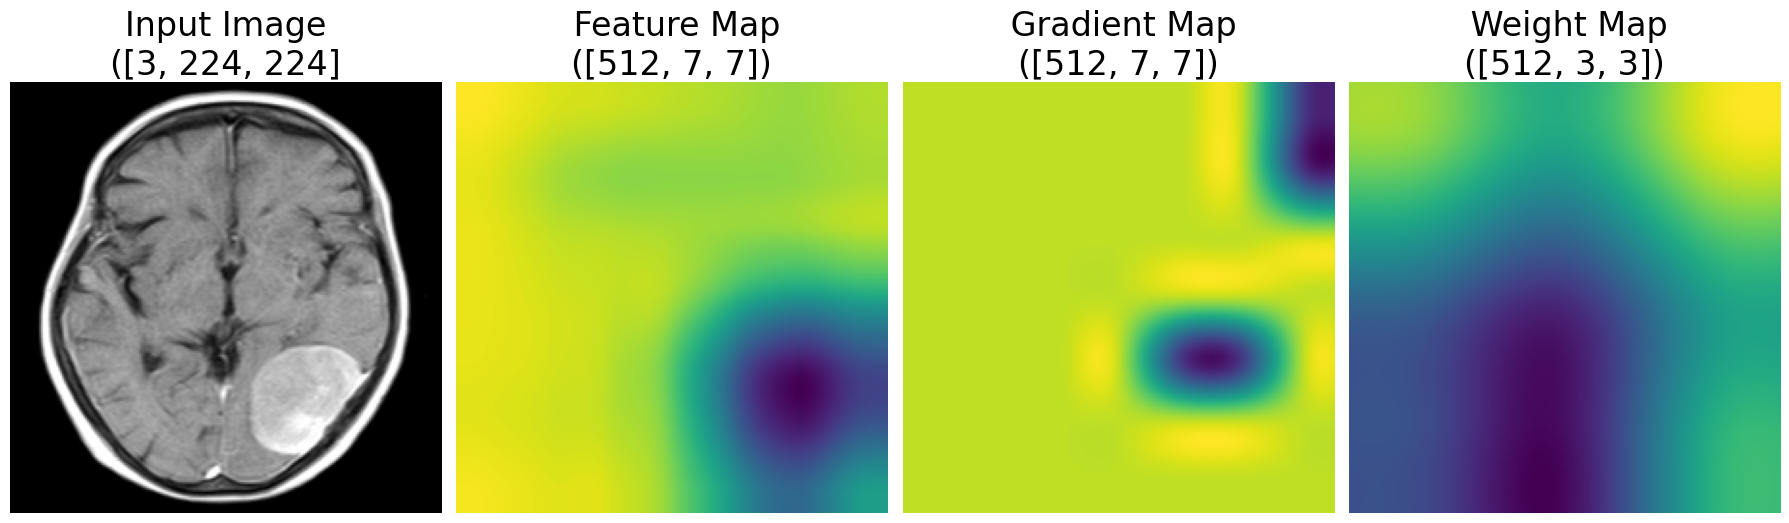

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import requests
from io import BytesIO

# -------------------------------
# Preprocessing (ImageNet standard)
# -------------------------------
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
my_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# -------------------------------
# Load the Image
# -------------------------------
# Here we use a local image (you can also load from URL if needed)
img_path = '/content/braintumor/Testing/meningioma/Te-me_0017.jpg'
img_meningioma = Image.open(img_path).convert('RGB').resize((224, 224))
img_tensor = my_transform(img_meningioma).unsqueeze(0)  # shape: [1, 3, 224, 224]

# -------------------------------
# Load the Model and Weights
# -------------------------------
model = models.resnet34()
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load('myweights/best_model.pth.tar', map_location=torch.device('cpu')))
model.eval()

# -------------------------------
# Hook Functions to Capture Feature Maps and Gradients
# -------------------------------
feature_maps = None
gradients = None

def forward_hook(module, input, output):
    global feature_maps
    feature_maps = output.detach()  # save the feature maps

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()  # save the gradients of the feature maps

# -------------------------------
# Choose Target Layer for Visualization
# -------------------------------
# For ResNet34, a good choice is the second convolution in the last BasicBlock:
target_layer = model.layer4[-1].conv2

# Register hooks on the target layer
fhook = target_layer.register_forward_hook(forward_hook)
bhook = target_layer.register_backward_hook(backward_hook)

# -------------------------------
# Forward and Backward Pass
# -------------------------------
# Forward pass
logits = model(img_tensor)
pred_class = logits.argmax(dim=1).item()
print("Predicted class:", pred_class)

# Backward pass: compute gradient of the predicted class score
loss = logits[0, pred_class]
model.zero_grad()
loss.backward()

# Extract the weights from the target layer (shape: [out_channels, in_channels, k, k])
weights = target_layer.weight.data.cpu().numpy()

# -------------------------------
# Visualization
# -------------------------------
# 1. Input Image
img_np = np.array(img_meningioma)

# 2. Random Feature Map
# feature_maps: shape [1, C, H, W]
fm = feature_maps.cpu().numpy()[0]  # shape: (C, H, W)
num_channels = fm.shape[0]
rand_idx = random.randint(0, num_channels - 1)
rand_idx = 504
rand_feature_map = fm[rand_idx]  # shape: (H, W)
# Upsample to image size (224x224) using cubic interpolation
rand_feature_map_up = cv2.resize(rand_feature_map, (224, 224), interpolation=cv2.INTER_CUBIC)

# 3. Random Gradient Map
# gradients: shape [1, C, H, W]
grads = gradients.cpu().numpy()[0]  # shape: (C, H, W)
rand_gradient_map = grads[rand_idx]  # use the same channel index
rand_gradient_map_up = cv2.resize(rand_gradient_map, (224, 224), interpolation=cv2.INTER_CUBIC)

# 4. Random Weight Map
# weights: shape [out_channels, in_channels, k, k]
# For the same output channel (filter) selected, average across input channels.
rand_weight = weights[rand_idx]           # shape: (in_channels, k, k)
avg_weight_map = np.mean(rand_weight, axis=0)  # shape: (k, k)
# Upsample the small kernel (e.g., 3x3) to 224x224 for visualization
weight_map_up = cv2.resize(avg_weight_map, (224, 224), interpolation=cv2.INTER_CUBIC)

# Utility function: Normalize a map to [0, 1]
def normalize_map(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

norm_feature = normalize_map(rand_feature_map_up)
norm_gradient = normalize_map(rand_gradient_map_up)
norm_weight = normalize_map(weight_map_up)

# Plot the input image, random feature map, gradient map, and weight map
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.imshow(img_np)
plt.title("Input Image\n([3, 224, 224]", fontsize=24)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(norm_feature, cmap="viridis")
plt.title(f" Feature Map\n([512, 7, 7])", fontsize=24)
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(norm_gradient, cmap="viridis")
plt.title(f" Gradient Map\n([512, 7, 7])", fontsize=24)
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(norm_weight, cmap="viridis")
plt.title(f" Weight Map\n([512, 3, 3])", fontsize=24)
plt.axis("off")

plt.tight_layout()
plt.show()

# Remove hooks when done
fhook.remove()
bhook.remove()


<ipython-input-21-b77d9b62ca8f>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('myweights/best_model.pth.tar', map_location=torch.device(

Predicted class: 1


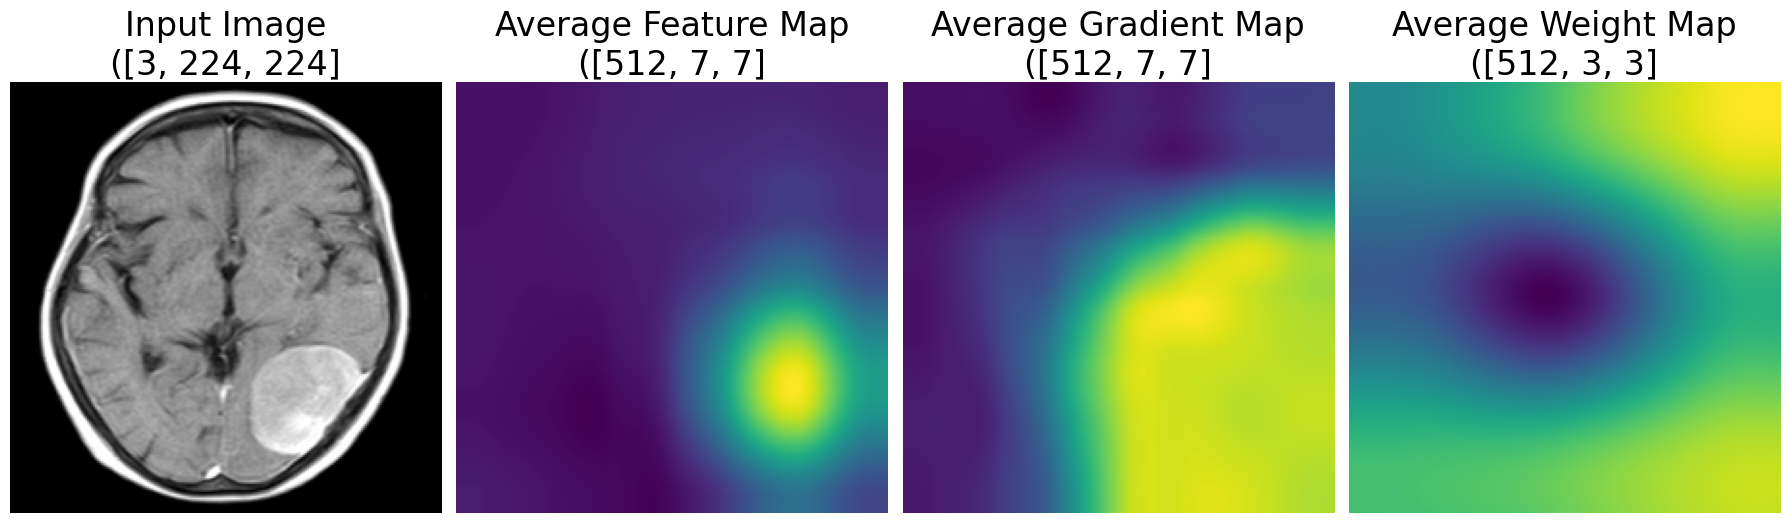

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import requests
from io import BytesIO

# Global variables to store feature maps and gradients
feature_maps = None
gradients = None

# Hook to capture forward output (feature maps)
def forward_hook(module, input, output):
    global feature_maps
    feature_maps = output.detach()

# Hook to capture gradients (of the feature maps)
def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()

# -------------------------------
# Load the ResNet34 model with your trained weights
# -------------------------------
model = models.resnet34()
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load('myweights/best_model.pth.tar', map_location=torch.device('cpu')))
model.eval()

# -------------------------------
# Choose the target layer for visualization
# For ResNet34, we select the second convolution of the last BasicBlock: model.layer4[-1].conv2
target_layer = model.layer4[-1].conv2

# Register the hooks on the target layer
fhook = target_layer.register_forward_hook(forward_hook)
bhook = target_layer.register_backward_hook(backward_hook)

# -------------------------------
# Define the preprocessing transform (ImageNet standard)
# -------------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------------------
# Load the image from local file (or URL)
# -------------------------------
img_path = '/content/braintumor/Testing/meningioma/Te-me_0017.jpg'
img_meningioma = Image.open(img_path).convert('RGB').resize((224, 224))
img_tensor = preprocess(img_meningioma).unsqueeze(0)  # shape: [1, 3, 224, 224]

# -------------------------------
# Forward Pass
# -------------------------------
logits = model(img_tensor)
pred_class = logits.argmax(dim=1).item()
print("Predicted class:", pred_class)

# -------------------------------
# Backward Pass to obtain gradients
# -------------------------------
loss = logits[0, pred_class]
model.zero_grad()
loss.backward()

# -------------------------------
# Extract the weights from the target layer
# -------------------------------
# For a convolution layer, weights shape is [out_channels, in_channels, kernel, kernel]
weights = target_layer.weight.data.cpu().numpy()

# -------------------------------
# Visualization
# -------------------------------

# 1. Input Image
img_np = np.array(img_meningioma)

# 2. Average Feature Map:
# feature_maps shape: [1, C, H, W] → average over the channel axis gives [H, W]
fm = feature_maps.cpu().numpy()[0]  # shape: (C, H, W)
avg_feature_map = np.mean(fm, axis=0)
# Upsample to image size (224x224) for visualization
avg_feature_map_up = cv2.resize(avg_feature_map, (224, 224), interpolation=cv2.INTER_CUBIC)

# 3. Average Gradient Map:
# gradients shape: [1, C, H, W] → average over channels gives [H, W]
grads = gradients.cpu().numpy()[0]  # shape: (C, H, W)
avg_gradient_map = np.mean(grads, axis=0)
avg_gradient_map_up = cv2.resize(avg_gradient_map, (224, 224), interpolation=cv2.INTER_CUBIC)

# 4. Average Weight Map:
# weights shape: [out_channels, in_channels, k, k] → average over out_channels and in_channels
avg_weight_map = np.mean(weights, axis=(0,1))
# Upsample the small kernel (e.g., 3x3) to 224x224 for visualization
avg_weight_map_up = cv2.resize(avg_weight_map, (224, 224), interpolation=cv2.INTER_CUBIC)

# Utility function to normalize maps to [0, 1]
def normalize_map(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

norm_feature = normalize_map(avg_feature_map_up)
norm_gradient = normalize_map(avg_gradient_map_up)
norm_weight = normalize_map(avg_weight_map_up)

# Plot the results
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.imshow(img_np)
plt.title("Input Image\n([3, 224, 224]", fontsize=24)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(norm_feature, cmap="viridis")
plt.title("Average Feature Map\n([512, 7, 7]", fontsize=24)
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(norm_gradient, cmap="viridis")
plt.title("Average Gradient Map\n([512, 7, 7]", fontsize=24)
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(norm_weight, cmap="viridis")
plt.title("Average Weight Map\n([512, 3, 3]", fontsize=24)
plt.axis("off")

plt.tight_layout()
plt.show()

# Remove hooks when done
fhook.remove()
bhook.remove()


DenseNet

In [ ]:
import torch
import torch.nn.functional as F

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    model.eval()
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap

model = models.densenet121()
model.classifier = nn.Linear(model.classifier.in_features, 4)
model.load_state_dict(torch.load('myweights/best_model_densenet8.pth.tar'))
img = my_transform(img_meningioma).unsqueeze(0)

# Write your code

Vision Transformer

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def reshape_transform(tensor, height=7, width=7):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    #Write your code to reshape and transpose the gradients and activations from [1, 50, 768] to [1, 7, 7, 768] to [1, 768, 7, 7]


    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap


model = models.vision_transformer.vit_b_32()
model.heads = nn.Linear(model.heads[0].in_features, 4)
model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar'))
img = my_transform(img_meningioma).unsqueeze(0)

# Write your code
